<h3>Work In Progress: Food Delivery Time Prediction
    
This notebook is a draft under development. Final model and pipeline will be added soon</h3>.


<h2>Importing Libraries and Loading Datasets</h2>

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split,GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [24]:
df=pd.read_csv("Food_Delivery_Times.csv")

In [25]:
df.sample(5)

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
598,570,7.29,Clear,High,Evening,Car,11,7.0,48
29,948,18.05,Clear,Medium,Evening,Scooter,10,7.0,123
776,710,13.79,Rainy,Low,Night,Scooter,11,0.0,69
856,881,5.01,Rainy,Low,Afternoon,Bike,10,5.0,31
933,242,19.10,Snowy,Low,Afternoon,Bike,18,1.0,101


<h2>Data Wrangling</h2>

In [26]:
df.columns

Index(['Order_ID', 'Distance_km', 'Weather', 'Traffic_Level', 'Time_of_Day',
       'Vehicle_Type', 'Preparation_Time_min', 'Courier_Experience_yrs',
       'Delivery_Time_min'],
      dtype='object')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


In [28]:
df.shape

(1000, 9)

In [29]:
df.describe()

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,1000.000000,970.000000,1000.000000
mean,500.500000,10.059970,16.982000,4.579381,56.732000
std,288.819436,5.696656,7.204553,2.914394,22.070915
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,250.750000,5.105000,11.000000,2.000000,41.000000
50%,500.500000,10.190000,17.000000,5.000000,55.500000
75%,750.250000,15.017500,23.000000,7.000000,71.000000
max,1000.000000,19.990000,29.000000,9.000000,153.000000


In [30]:
df.describe(include="object")

,Weather,Traffic_Level,Time_of_Day,Vehicle_Type
count,970,970,970,1000
unique,5,3,4,3
top,Clear,Medium,Morning,Bike
freq,470,390,308,503


In [31]:
df.isnull().sum()

Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

In [32]:
df.corr(numeric_only=True)

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
Order_ID,1.000000,-0.024483,-0.035100,0.013152,-0.036650
Distance_km,-0.024483,1.000000,-0.009037,-0.007842,0.780998
Preparation_Time_min,-0.035100,-0.009037,1.000000,-0.030830,0.307350
Courier_Experience_yrs,0.013152,-0.007842,-0.030830,1.000000,-0.090433
Delivery_Time_min,-0.036650,0.780998,0.307350,-0.090433,1.000000


<h4> Order ID and courier experience seem to have very little effect on the delivery time, on the other hand, preparation time plays a role in estimation of delivery time and distance has very high correlation with delivery time.</h4>

In [33]:
df.duplicated().sum()#There are no duplicated rows in the dataset

0

<h2>Exploratory Data Analysis</h2>

In [37]:
df_eda=df.copy()#Creating a duplicate for the dataframe to temporarily fill out the missing values and then perform EDA

In [38]:
for col in ['Weather', 'Traffic_Level', 'Time_of_Day']:
    df_eda[col].fillna(df_eda[col].mode()[0], inplace=True)
    
df_eda['Courier_Experience_yrs'].fillna(df_eda['Courier_Experience_yrs'].median(), inplace=True)

In [39]:
df_eda.isnull().sum()

Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64

In [44]:
num_cols=['Distance_km','Preparation_Time_min','Courier_Experience_yrs','Delivery_Time_min']

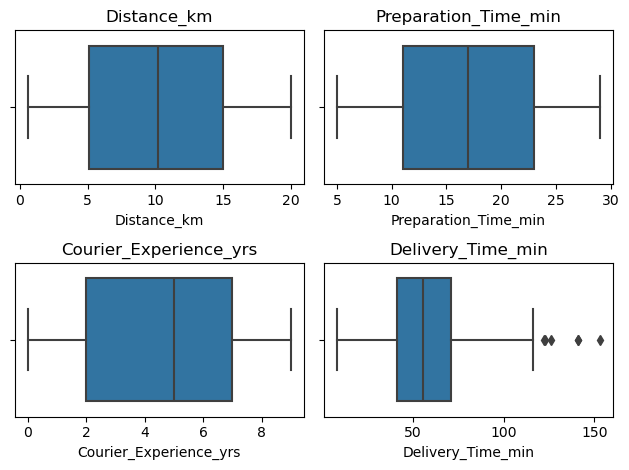

In [45]:
for i,col in enumerate(num_cols):
    plt.subplot(2,2,i+1)
    sns.boxplot(data=df_eda,x=col)
    plt.title(col)
plt.tight_layout()
plt.show()

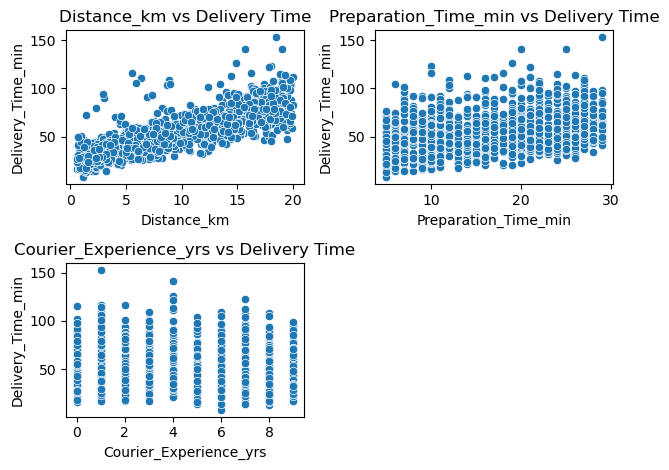

In [49]:
for i,col in enumerate(['Distance_km','Preparation_Time_min','Courier_Experience_yrs']):
    plt.subplot(2,2,i+1)
    sns.scatterplot(data=df_eda,x=col,y='Delivery_Time_min')
    plt.title(f"{col} vs Delivery Time")
plt.tight_layout()
plt.show()

In [ ]:
cat_cols=

<h2>Feature Engineering</h2>

In [34]:
df.drop("Order_ID",axis=1,inplace=True)#Order ID doesnot contribute in estimating the delivery time

In [35]:
df.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [ ]:
# X=df.drop('Delivery_Time_min',axis=1)
# y=df['Delivery_Time_min']

In [ ]:
# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
# num_cols=['Distance_km','Preparation_Time_min','Courier_Experience_yrs']